In [1]:
import tensorflow as tf

print("Tensorflow version: ", tf.__version__)

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

Tensorflow version:  2.2.0-rc4


We import the MNIST dataset, with 60000 samples of 28 x 28 images.

In [2]:
(mnist_images, labels), (_, _) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


(60000, 28, 28)

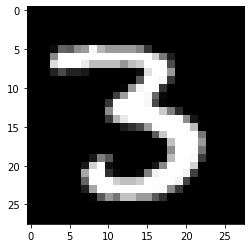

In [3]:
plt.imshow(mnist_images[12], cmap='gray')
mnist_images.shape

In [0]:
train_images = mnist_images.reshape(mnist_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [5]:
train_images.shape

(60000, 28, 28, 1)

Here we build a tensorflow dataset for our normalized data, that are then shuffled and divided into batches.

In [0]:
BUFFER_SIZE = train_images.shape[0]     # we choose a buffer size big as the entire dataset, for a more proper shuffeling
BATCH_SIZE = 256

# Creating tensorflow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)

# Shuffeling data
train_dataset = train_dataset.shuffle(BUFFER_SIZE)

# Creating batches
train_dataset = train_dataset.batch(BATCH_SIZE)

We define a function to construct the generator, that is a deep network able to generate images of the same size of the input ones.

According to Goodfellow paper, batch normalization has to be used in most layers of both the generator and the discriminator,2015), with the two minibatches for the discriminator normalized separately. The last layer of the generator and first layer of the discriminator are not batch normalized, so that the model can learn the correct mean and scale of the data distribution

We use Conv2DTranspose, that represent Deconvolutional layers, to generate new images: this objects work in the opposite direction respect to the traditional convolutional layers, they use their smaller input to learn its larger representation, our final image. <br>
Notice also that the activation functions used are almost everywhere LeakyRelu, that is a "leaky" version of the ReLU, and it is used because it allows a small gradient when the unit is not active, reducing the impact on the successive minimization via gradient descent.

In [0]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())   
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Let's try to use the (untrained) generator to create an image.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

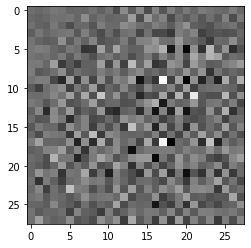

In [8]:
generator = make_generator_model()
generator.summary()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

The discriminator is just a CNN.

In [0]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [0]:
discriminator = make_discriminator_model()
discriminator.summary()
decision = discriminator(generated_image)
print(decision)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

The next step is to define loss functions and optimizers for both models.

The discriminator's loss quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

I think that this is the simpler "minimax" version of the problem, as described by Goodfellow, since we will minimize the sum of the two (identical errors). Should we try also with the "non euristic" or the "maximum likelihood methods"?


In [0]:
# This method returns a function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(y_true=tf.ones_like(real_output),  y_pred=real_output)
    fake_loss = cross_entropy(y_true=tf.zeros_like(fake_output), y_pred=fake_output)
    total_loss = real_loss + fake_loss
    return total_loss 

def generator_loss(fake_output):
    return cross_entropy(y_true=tf.ones_like(fake_output), y_pred=fake_output)

Then we need also to define the optimizers for the two networks indipendently, since they will be trained separatey. <br>
The usage of Adam respect to SGD is suggested by Goodfellow. We can anyway feel free to modify the learning_rate or the moments used in the parameters of the function. 

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

We want also to implement the possibility of saving and restoring the models, which can be helpful in case a long running training task is interrupted. <br>
The function CheckPoint takes as arguments the models and the optimizers to use.

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

Now it's time to define the training process.

In [0]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with the generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

(I didn't understood very well how these gradients work)

In [0]:
# @tf.function is a decorator provided by Tensorflow for computationally expensive functions: using it, 
# you compile a Python function in a graph, providing distributed training benefits and optimizing the process
@tf.function
def train_step(images):
    
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

Define a function to save the images generated.

In [0]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [0]:
training_start_time = time.time()
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ("Time for epoch {} is {} sec".format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

Calling the train() method defined above you train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate). <br>
At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

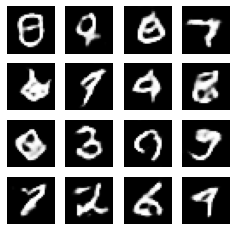

In [0]:
train(train_dataset, EPOCHS)

To restore the latest checkpoint

In [0]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Let's create a GIF to visualize the learning phases of the GAN.


In [0]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

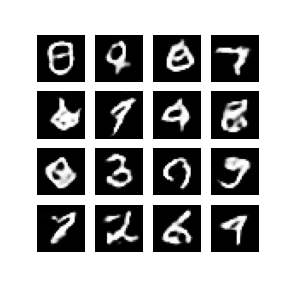

In [0]:
display_image(EPOCHS)

In [0]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

To download the GIF form colab

In [0]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)